# Analisis Sentimen menggunakan Transformer

## Import Library

In [ ]:
# Sastrawi untuk Stemming Bahasa Indonesia
!pip install Sastrawi tqdm

import pandas as pd
import numpy as np
import re
import os
import json
import seaborn as sns

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Input, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas()

## Load Data

In [ ]:
DATA_DIR = '/content'

In [ ]:
# Dictionary untuk menampung semua data yang dimuat
data = {}

print("Memulai proses memuat data...\n")

try:
    # --- 1. MEMUAT DATASET SENTIMEN (FORMAT .CSV) ---
    # pd.read_csv() adalah fungsi standar untuk file .csv
    print("Memuat dataset sentimen...")
    data['sentiment_pilkada_dki'] = pd.read_csv(os.path.join(DATA_DIR, 'dataset_tweet_sentiment_pilkada_DKI_2017.csv'))

    # Untuk file .txt, kita baca baris per baris
    print("\nMemuat file teks tambahan...")
    with open(os.path.join(DATA_DIR, 'combined_stop_words.txt'), 'r') as f:
        data['stop_words'] = [line.strip() for line in f.readlines()]

    with open(os.path.join(DATA_DIR, 'combined_slang_words.txt'), 'r') as f:
        # Untuk slang, kita perlu mapping dari slang -> baku. Kita asumsikan formatnya "slang:baku"
        slang_map = {}
        for line in f:
            if ':' in line:
                slang, formal = line.strip().split(':', 1)
                slang_map[slang.strip()] = formal.strip()
        data['slang_words'] = slang_map

    with open(os.path.join(DATA_DIR, 'combined_root_words.txt'), 'r') as f:
        data['root_words'] = [line.strip() for line in f.readlines()]

    print("\nSemua data berhasil dimuat ke dalam dictionary 'data'!")

except FileNotFoundError as e:
    print(f"\nERROR: File tidak ditemukan! Pastikan path '{DATA_DIR}' sudah benar dan file ada di dalamnya.")
    print(f"Detail error: {e}")

Memulai proses memuat data...

Memuat dataset sentimen...

Memuat file teks tambahan...

Semua data berhasil dimuat ke dalam dictionary 'data'!


## Lihat Preview Data

In [ ]:
print("\n--- sentiment_pilkada_dki ---")
display(data['sentiment_pilkada_dki'].head())


--- sentiment_pilkada_dki ---


,Id,Sentiment,Pasangan Calon,Text Tweet
0,1,negative,Agus-Sylvi,Banyak akun kloning seolah2 pendukung #agussil...
1,2,negative,Agus-Sylvi,#agussilvy bicara apa kasihan yaa...lap itu ai...
2,3,negative,Agus-Sylvi,Kalau aku sih gak nunggu hasil akhir QC tp lag...
3,4,negative,Agus-Sylvi,Kasian oh kasian dengan peluru 1milyar untuk t...
4,5,negative,Agus-Sylvi,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...


## Ubah Nama Kolom


In [ ]:
# --- Memproses dataset_tweet_sentiment_pilkada_DKI_2017.csv ---
try:
    path_pilkada = os.path.join(DATA_DIR, 'dataset_tweet_sentiment_pilkada_DKI_2017.csv')
    df_pilkada = pd.read_csv(path_pilkada)
    # Pilih kolom yang relevan dan ganti namanya.
    df_pilkada_clean = df_pilkada[['Text Tweet', 'Sentiment']].rename(
        columns={'Text Tweet': 'text', 'Sentiment': 'sentiment'}
    )
    print(f"Berhasil memproses {len(df_pilkada_clean)} data sentimen Pilkada DKI.")

except Exception as e:
    print(f"Gagal memproses dataset_tweet_sentiment_pilkada_DKI_2017.csv: {e}")

Berhasil memproses 900 data sentimen Pilkada DKI.


## Lihat Data

In [ ]:
  # Menghapus baris yang teksnya kosong (jika ada)
  df_pilkada_clean.dropna(subset=['text'], inplace=True)

  print("\n---------------------------------------------------------")
  print(f"Total data sentimen pilkada: {len(df_pilkada_clean)} baris.")
  print("---------------------------------------------------------\n")

  # --- Analisis pada Data Pilkada ---
  print("Analisis Data Pilkada DKI:")

  # Tampilkan 10 sampel acak dari data
  print("\n[1] Sampel Acak Data:")
  display(df_pilkada_clean.sample(10))

  # Cek distribusi label sentimen
  print("\n[2] Distribusi Label Sentimen:")
  print(df_pilkada_clean['sentiment'].value_counts())

  # Cek info DataFrame
  print("\n[3] Info DataFrame:")
  df_pilkada_clean.info()


---------------------------------------------------------
Total data sentimen pilkada: 900 baris.
---------------------------------------------------------

Analisis Data Pilkada DKI:

[1] Sampel Acak Data:


,text,sentiment
436,Tidak usah mikir coblos sebelah kiri #ahokdjar...,negative
149,Sekarang tinggal tunggu sikap #AHY terhadap ma...,negative
141,Pak @SBYudhoyono jangan biarkan pengorbanan da...,negative
804,Terima kasih kepada warga Jakarta yang telah m...,positive
519,Paduan suara warga di balai kota #ahokdjarot,positive
85,"AHY Kalah di Kandang, Begini Respon Para Tetan...",negative
87,Gagal di Pilkada DKI Jakarta AHY Diisukan Maju...,negative
570,Kepada Pendukung #BaDja #AhokDjarot kita tidak...,positive
330,Kubu BaDja Sindir Anies Soal Spanduk Jakarta B...,negative
92,"Jual baju bekas AHY, baru 3 bulan, PM for info...",negative



[2] Distribusi Label Sentimen:
sentiment
negative    450
positive    450
Name: count, dtype: int64

[3] Info DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       900 non-null    object
 1   sentiment  900 non-null    object
dtypes: object(2)
memory usage: 14.2+ KB


## Ambil data dari kolom 'text'

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Kita menggunakan .astype(str) untuk memastikan semua data adalah string
texts_raw = df_pilkada_clean['text'].astype(str).values
labels_raw = df_pilkada_clean['sentiment'].values

## Buat tokenizer

In [ ]:
# Penting untuk membuat tokenizer baru dan melatihnya pada data mentah
# Tokenizer Keras secara default akan:
# 1. Mengubah ke lowercase (lower=True)
# 2. Menghapus tanda baca dasar (filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\\t\\n')
# Ini menjaga kata-kata penting tetap utuh
vocab_size_raw = 10000
oov_token_raw = "<OOV>"

tokenizer_raw = Tokenizer(num_words=vocab_size_raw, oov_token=oov_token_raw)
tokenizer_raw.fit_on_texts(texts_raw)

# Ubah teks menjadi sekuens
sequences_raw = tokenizer_raw.texts_to_sequences(texts_raw)

## Padding Sequences

In [ ]:
maxlen_raw = 100 # Kita samakan panjangnya dengan eksperimen sebelumnya
padded_raw = pad_sequences(sequences_raw, maxlen=maxlen_raw, padding='post', truncating='post')

## Encode Label

In [ ]:
label_encoder_raw = LabelEncoder()
encoded_labels_raw = label_encoder_raw.fit_transform(labels_raw)
num_labels_raw = len(np.unique(encoded_labels_raw))

## Split Data

In [ ]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    padded_raw, encoded_labels_raw, test_size=0.2,
    random_state=42, stratify=encoded_labels_raw
)

print("Data mentah (raw) berhasil di-tokenize dan di-split:")
print(f"Bentuk X_train_raw: {X_train_raw.shape}")
print(f"Bentuk X_test_raw: {X_test_raw.shape}")

Data mentah (raw) berhasil di-tokenize dan di-split:
Bentuk X_train_raw: (720, 100)
Bentuk X_test_raw: (180, 100)


## Inspeksi Hasil Transformasi Data

In [ ]:
# Kita akan melihat sampel pertama (indeks 0)
index_to_inspect = 0

print(f"--- Inspeksi Data Sampel Indeks: {index_to_inspect} ---\n")

# 1. Teks Asli
print(f"1. Teks Asli:\n{texts_raw[index_to_inspect]}\n")

# 2. Teks setelah menjadi Sekuens (dari Tokenizer)
print(f"2. Hasil Sekuens Angka (dari tokenizer_raw):\n{sequences_raw[index_to_inspect]}\n")

# 3. Hasil Sekuens setelah Padding
print(f"3. Hasil Sekuens setelah Padding (maxlen={maxlen_raw}):\n{padded_raw[index_to_inspect]}\n")

--- Inspeksi Data Sampel Indeks: 0 ---

1. Teks Asli:
Banyak akun kloning seolah2 pendukung #agussilvy mulai menyerang paslon #aniessandi dengan opini dan argumen pmbenaran..jangan terkecoh

2. Hasil Sekuens Angka (dari tokenizer_raw):
[87, 192, 1415, 1416, 49, 116, 285, 854, 101, 9, 33, 1417, 6, 1418, 1419, 41, 1420]

3. Hasil Sekuens setelah Padding (maxlen=100):
[  87  192 1415 1416   49  116  285  854  101    9   33 1417    6 1418
 1419   41 1420    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]



## Buat Arsitektur Model Transformer

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, MultiHeadAttention, Dense,
    LayerNormalization, GlobalAveragePooling1D, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- Parameter Model ---
embed_dim = 64      # Dimensi Embedding (d_model di paper Anda)
num_heads = 4       # Jumlah Attention Heads
ff_dim = 64         # Ukuran lapisan tersembunyi di Feed Forward network

# --- Gunakan parameter dari tokenizer BARU ---
inputs = Input(shape=(maxlen_raw,))

# Gunakan vocab_size_raw
token_embedding_layer = Embedding(input_dim=vocab_size_raw, output_dim=embed_dim)
token_embeddings = token_embedding_layer(inputs)

# Gunakan maxlen_raw
pos_embedding_layer = Embedding(input_dim=maxlen_raw, output_dim=embed_dim)
positions = tf.range(start=0, limit=maxlen_raw, delta=1)
pos_embeddings = pos_embedding_layer(positions)

x = token_embeddings + pos_embeddings

# --- Transformer Encoder Block ---
attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
attn_output = Dropout(0.1)(attn_output)
out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

ffn_output = Dense(ff_dim, activation="relu")(out1)
ffn_output = Dense(embed_dim)(ffn_output)
ffn_output = Dropout(0.1)(ffn_output)
x = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

# --- Classification Head ---
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.1)(x)

# Gunakan num_labels_raw
outputs = Dense(num_labels_raw, activation="softmax")(x)

# --- Buat dan Kompilasi Model ---
model_transformer_raw = Model(inputs=inputs, outputs=outputs)
model_transformer_raw.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print("--- Arsitektur Model Transformer ---")
model_transformer_raw.summary()

--- Arsitektur Model Transformer ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 64)   │    640,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 64)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 64)   │     66,368 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 100, 64)   │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100, 64)   │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100, 64)   │      4,160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 100, 64)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 100, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │         66 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 717,090 (2.74 MB)

 Trainable params: 717,090 (2.74 MB)

 Non-trainable params: 0 (0.00 B)

## Train data awal

In [ ]:
print("\n--- Memulai Training Model Transformer pada Data Mentah ---")

batch_size = 32
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

history_transformer_raw = model_transformer_raw.fit(
    X_train_raw, y_train_raw,
    batch_size=batch_size,
    epochs=10, # Kita set 20, tapi EarlyStopping mungkin akan berhenti lebih cepat
    validation_data=(X_test_raw, y_test_raw),
    # callbacks=[early_stopping]
)

print("\n--- Training Model Transformer Selesai ---")


--- Memulai Training Model Transformer pada Data Mentah ---
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.4120 - loss: 0.9624 - val_accuracy: 0.5000 - val_loss: 0.6959
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.5064 - loss: 0.6974 - val_accuracy: 0.5000 - val_loss: 0.7101
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.5017 - loss: 0.6989 - val_accuracy: 0.5000 - val_loss: 0.6920
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.4864 - loss: 0.7082 - val_accuracy: 0.5000 - val_loss: 0.6914
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.5334 - loss: 0.6916 - val_accuracy: 0.5000 - val_loss: 0.7033
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.5631 - loss: 0.6880 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.5655 - loss: 0.6769 - val_accuracy: 0.6500 - val_loss: 0.6660
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 15

## Plot Hasil

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(history, title):
    """Fungsi untuk memplot grafik accuracy dan loss."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot Akurasi
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
    ax1.set_title(f'Akurasi Model - {title}')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    # Plot Loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
    ax2.set_title(f'Loss Model - {title}')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.suptitle(f'Analisis Training untuk {title}', fontsize=16)
    plt.show()

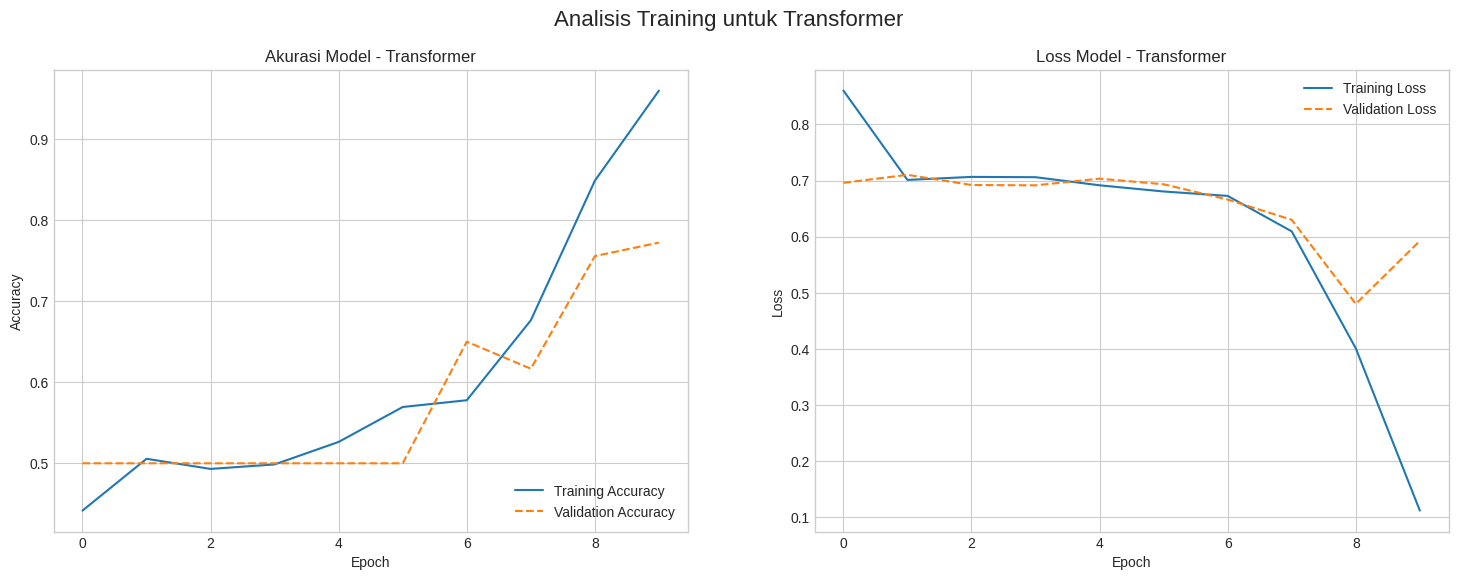

In [ ]:
plot_training_history(history_transformer_raw, "Transformer")

--- Mengevaluasi Model Transformer pada Data Uji ---



6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step

--- Laporan Klasifikasi ---
              precision    recall  f1-score   support

    negative       0.79      0.74      0.77        90
    positive       0.76      0.80      0.78        90

    accuracy                           0.77       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.77      0.77      0.77       180



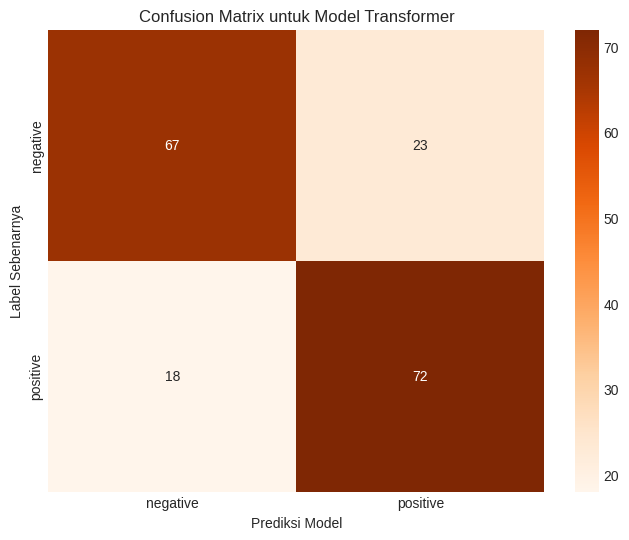

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("--- Mengevaluasi Model Transformer pada Data Uji ---\n")

# Lakukan prediksi pada data uji
y_pred_probs_tf_raw = model_transformer_raw.predict(X_test_raw)
y_pred_tf_raw = np.argmax(y_pred_probs_tf_raw, axis=1)

# Dapatkan nama label
target_names_raw = label_encoder_raw.classes_

# Tampilkan Laporan Klasifikasi
print("\n--- Laporan Klasifikasi ---")
print(classification_report(y_test_raw, y_pred_tf_raw, target_names=target_names_raw))

cm_tf_raw = confusion_matrix(y_test_raw, y_pred_tf_raw)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tf_raw, annot=True, fmt='d', cmap='Oranges', xticklabels=target_names_raw, yticklabels=target_names_raw)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix untuk Model Transformer')
plt.show()

## Praproses

In [ ]:
# Buat sebuah dictionary (cache) untuk menyimpan hasil stemming
stem_cache = {}
# Juga buat cache untuk seluruh proses
preprocess_cache = {}

factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(data['stop_words'])
slang_map = data['slang_words']


def preprocess_text_cached(text):
    if not isinstance(text, str):
        return ""

    # Cek apakah seluruh teks sudah pernah diproses
    if text in preprocess_cache:
        return preprocess_cache[text]

    # 1. & 2. Case Folding & Cleaning (proses ini cepat, tidak perlu cache)
    processed_text = text.lower()
    processed_text = re.sub(r'http\S+|www\S+|https\S+', '', processed_text, flags=re.MULTILINE)
    processed_text = re.sub(r'\@\w+|\#\w+', '', processed_text)
    processed_text = re.sub(r'\d+', '', processed_text)
    processed_text = re.sub(r'[^a-zA-Z\s]', '', processed_text)
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()

    # 3. & 4. Normalisasi & Stopword Removal (juga relatif cepat)
    words = processed_text.split()
    normalized_words = [slang_map[word] if word in slang_map else word for word in words]
    filtered_words = [word for word in normalized_words if word not in stop_words]

    # 5. Stemming dengan Cache
    stemmed_words = []
    for word in filtered_words:
        if word in stem_cache:
            stemmed_words.append(stem_cache[word])
        else:
            stemmed_word = stemmer.stem(word)
            stem_cache[word] = stemmed_word
            stemmed_words.append(stemmed_word)

    final_text = ' '.join(stemmed_words)

    # Simpan hasil akhir ke cache utama
    preprocess_cache[text] = final_text

    return final_text

In [ ]:
print("Memulai preprocessing pada data sentimen...")

# Membuat kolom baru 'text_clean' dengan menerapkan fungsi preprocessing
# .progress_apply() berasal dari tqdm dan akan menampilkan progress bar
df_pilkada_clean['text_clean'] = df_pilkada_clean['text'].progress_apply(preprocess_text_cached)

print("\n Preprocessing data sentimen selesai.")
print("Berikut perbandingan teks asli dan teks bersih:")

# Tampilkan kolom asli dan kolom yang sudah bersih untuk perbandingan
display(df_pilkada_clean[['text', 'text_clean']].sample(10))

Memulai preprocessing pada data sentimen...


100%|██████████| 900/900 [02:40<00:00,  5.61it/s]


 Preprocessing data sentimen selesai.
Berikut perbandingan teks asli dan teks bersih:


,text,text_clean
91,"Kasihan AHY kalah walaupun sudah umroh, dibant...",kasihan ahy kalah umroh bantu doa juta umatter...
23,"#ahy, pakdhe karwo, Pilgub Jatim, Pak Dhe Karw...",pakdhe karwo pilgub jatim dhe karwo isyarat ag...
486,"Pelajaran Kesabaran dari ""The Invisible"" Djaro...",ajar sabar invisible djarot
530,Bukan hanya di jakarta saja tapi di medan juga...,jakarta medan
821,"Cfd bersama sandiaga uno..seru,rame & menyehat...",cfd sandiaga unoserurame sehat
578,Baju Seragam buat nyoblos sudah siap nih teman...,baju seragam nyoblos nih temanteman
135,Versi #3 video #AHYANGaruk2Kepala terlihat bin...,versi video bingung bicara banjir kota apung f...
798,@temanAhok @sahaL_AS @GunRomli @addiems Karang...,karang bunga mati kekuasaannyaakan akhir welcome
879,Kita semua saudara!! #PilkadaSerentak2017 #Pil...,saudara
252,"WalauPun kau kalah,Kami tetap bangga sekali pa...",kau kalahkami bangga pada jalan panjangkesukse...


In [ ]:
save_path_sentiment = os.path.join(DATA_DIR, 'sentiment_clean_without#@.feather')
df_pilkada_clean.to_feather(save_path_sentiment)

print(f"File Sentimen berhasil disimpan di: {save_path_sentiment}")

File Sentimen berhasil disimpan di: /content/sentiment_clean_without#@.feather


In [ ]:
df_pilkada_clean_withouttag = pd.read_feather('/content/sentiment_clean_without#@.feather')
print("Data bersih berhasil dimuat kembali!")

display(df_pilkada_clean_withouttag.head())

Data bersih berhasil dimuat kembali!


,text,sentiment,text_clean
0,Banyak akun kloning seolah2 pendukung #agussil...,negative,akun kloning dukung serang paslon opini argume...
1,#agussilvy bicara apa kasihan yaa...lap itu ai...,negative,bicara kasihan yaalap air mata wkwkwkwk
2,Kalau aku sih gak nunggu hasil akhir QC tp lag...,negative,sih gak nunggu hasil qc tp nunggu motif cuit k...
3,Kasian oh kasian dengan peluru 1milyar untuk t...,negative,kasi kasi peluru milyar rw mempan menangin pil...
4,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...,negative,maaf dukung hayo dukung putar


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# --- 1. AMBIL DATA DARI KOLOM 'text_clean' (BARU) ---
texts_clean = df_pilkada_clean_withouttag['text_clean'].astype(str).values
labels_clean = df_pilkada_clean_withouttag['sentiment'].values

# --- 2. BUAT TOKENIZER BARU UNTUK DATA BERSIH ---
vocab_size_clean = 10000
oov_token_clean = "<OOV>"

tokenizer_clean = Tokenizer(num_words=vocab_size_clean, oov_token=oov_token_clean)
tokenizer_clean.fit_on_texts(texts_clean)

# Ubah teks menjadi sekuens
sequences_clean = tokenizer_clean.texts_to_sequences(texts_clean)

# --- 3. PADDING SEQUENCES ---
maxlen_clean = 100 # Samakan panjangnya
padded_clean = pad_sequences(sequences_clean, maxlen=maxlen_clean, padding='post', truncating='post')

# --- 4. ENCODE LABELS ---
label_encoder_clean = LabelEncoder()
encoded_labels_clean = label_encoder_clean.fit_transform(labels_clean)
num_labels_clean = len(np.unique(encoded_labels_clean))

# --- 5. SPLIT DATA BERSIH ---
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    padded_clean, encoded_labels_clean, test_size=0.2, random_state=42, stratify=encoded_labels_clean
)

print("Data bersih (clean) berhasil di-tokenize dan di-split:")
print(f"Bentuk X_train_clean: {X_train_clean.shape}")
print(f"Bentuk X_test_clean: {X_test_clean.shape}")

Data bersih (clean) berhasil di-tokenize dan di-split:
Bentuk X_train_clean: (720, 100)
Bentuk X_test_clean: (180, 100)


In [ ]:
# --- Latih Model ---
print("\n--- Memulai Training Model Transformer pada Data bersih tanpa tag dan mention ---")
batch_size = 32
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history_transformer_clean_withouttag = model_transformer_raw.fit(
    X_train_clean, y_train_clean,
    batch_size=batch_size,
    epochs=10,
    validation_data=(X_test_clean, y_test_clean),
    # callbacks=[early_stopping]
)

print("\n--- Training Model Transformer (Data bersih tanpa tag dan mention) Selesai ---")


--- Memulai Training Model Transformer pada Data bersih tanpa tag dan mention ---
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.5333 - loss: 0.7435 - val_accuracy: 0.5000 - val_loss: 0.7083
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.5276 - loss: 0.7148 - val_accuracy: 0.5167 - val_loss: 0.6881
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.5457 - loss: 0.6887 - val_accuracy: 0.5000 - val_loss: 0.7048
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.5164 - loss: 0.6976 - val_accuracy: 0.5000 - val_loss: 0.7166
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.5221 - loss: 0.6933 - val_accuracy: 0.5111 - val_loss: 0.6852
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.5194 - loss: 0.6918 - val_accuracy: 0.5111 - val_loss: 0.6805
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.6116 - loss: 0.6547 - val_accuracy: 0.5444 - val_loss: 0.6686
Epoch 8/10
23/23 ━━━━

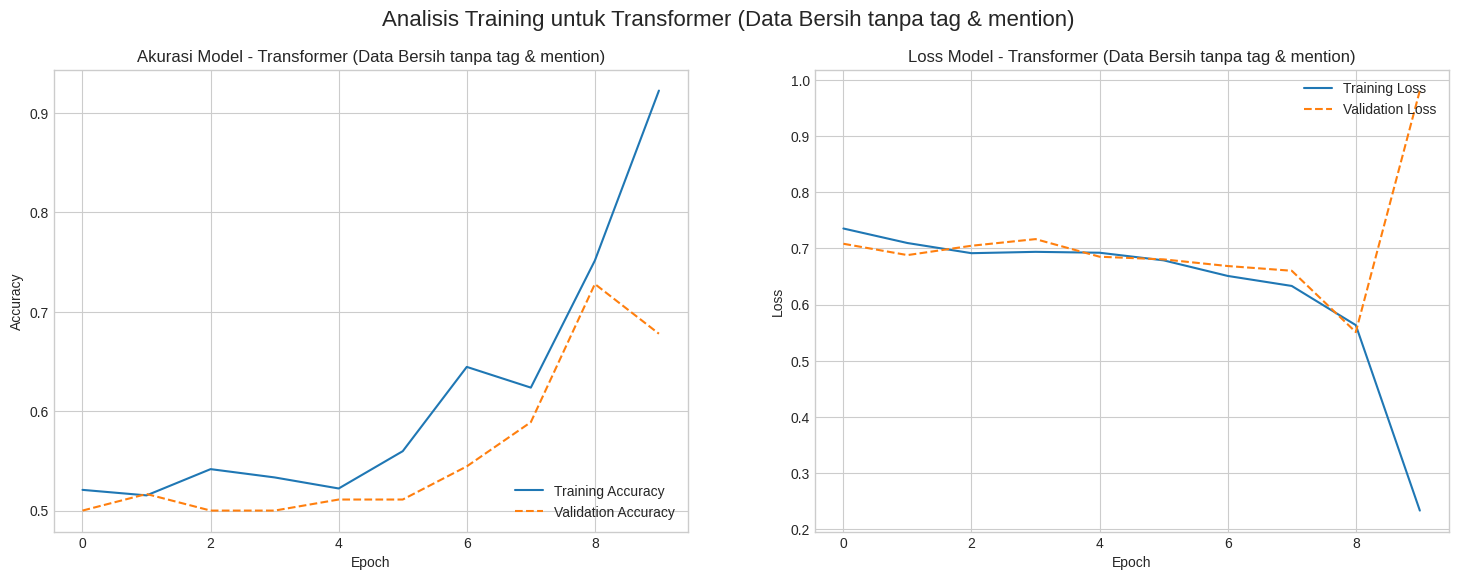


--- Mengevaluasi Model Transformer (Data Bersih tanpa tag & mention) pada Data Uji ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step

--- Laporan Klasifikasi (Transformer - Data Bersih tanpa tag & mention) ---
              precision    recall  f1-score   support

    negative       0.66      0.74      0.70        90
    positive       0.71      0.61      0.65        90

    accuracy                           0.68       180
   macro avg       0.68      0.68      0.68       180
weighted avg       0.68      0.68      0.68       180



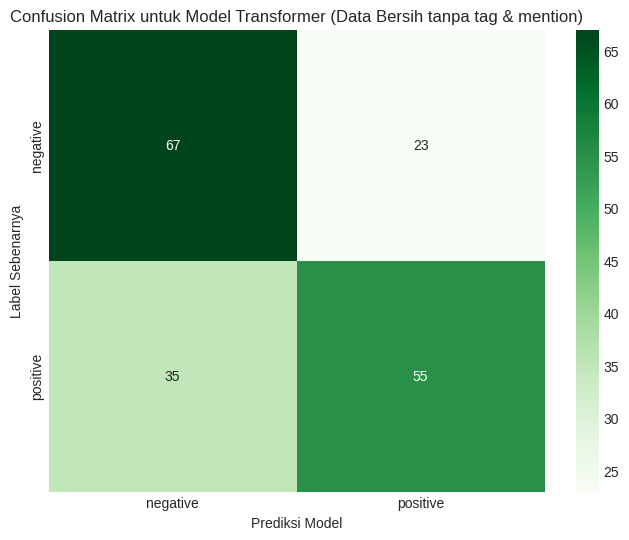

In [ ]:
plot_training_history(history_transformer_clean_withouttag, "Transformer (Data Bersih tanpa tag & mention)")

# --- Laporan Klasifikasi dan Confusion Matrix (Data Uji) ---
print("\n--- Mengevaluasi Model Transformer (Data Bersih tanpa tag & mention) pada Data Uji ---")

y_pred_probs_tf_clean = model_transformer_raw.predict(X_test_clean)
y_pred_tf_clean = np.argmax(y_pred_probs_tf_clean, axis=1)

target_names_clean = label_encoder_clean.classes_

print("\n--- Laporan Klasifikasi (Transformer - Data Bersih tanpa tag & mention) ---")
print(classification_report(y_test_clean, y_pred_tf_clean, target_names=target_names_clean))

cm_tf_clean = confusion_matrix(y_test_clean, y_pred_tf_clean)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tf_clean, annot=True, fmt='d', cmap='Greens', xticklabels=target_names_clean, yticklabels=target_names_clean)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix untuk Model Transformer (Data Bersih tanpa tag & mention)')
plt.show()

### test2


### Persiapan Tools

In [ ]:
# Buat sebuah dictionary (cache) untuk menyimpan hasil stemming
stem_cache = {}
# Juga buat cache untuk seluruh proses
preprocess_cache = {}

factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(data['stop_words'])
slang_map = data['slang_words']


def preprocess_text_cached_withtag(text):
    if not isinstance(text, str):
        return ""

    # Cek apakah seluruh teks sudah pernah diproses
    if text in preprocess_cache:
        return preprocess_cache[text]

    # 1. & 2. Case Folding & Cleaning (proses ini cepat, tidak perlu cache)
    processed_text = text.lower() # Assign the lowercased text here
    processed_text = re.sub(r'http\S+|www\S+|https\S+', '', processed_text, flags=re.MULTILINE)
    # processed_text = re.sub(r'\@\w+|\#\w+', '', processed_text)
    processed_text = re.sub(r'\d+', '', processed_text)
    processed_text = re.sub(r'[^a-zA-Z\s]', '', processed_text)
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()

    # 3. & 4. Normalisasi & Stopword Removal (juga relatif cepat)
    words = processed_text.split()
    normalized_words = [slang_map[word] if word in slang_map else word for word in words]
    filtered_words = [word for word in normalized_words if word not in stop_words]

    # 5. Stemming dengan Cache
    stemmed_words = []
    for word in filtered_words:
        if word in stem_cache:
            stemmed_words.append(stem_cache[word])
        else:
            stemmed_word = stemmer.stem(word)
            stem_cache[word] = stemmed_word
            stemmed_words.append(stemmed_word)

    final_text = ' '.join(stemmed_words)

    # Simpan hasil akhir ke cache utama
    preprocess_cache[text] = final_text

    return final_text

### Terapkan pada Dataframe

In [ ]:
print("Memulai preprocessing pada data sentimen...")

# Membuat kolom baru 'text_clean' dengan menerapkan fungsi preprocessing
# .progress_apply() berasal dari tqdm dan akan menampilkan progress bar
df_pilkada_clean['text_clean'] = df_pilkada_clean['text'].progress_apply(preprocess_text_cached_withtag)

print("\n Preprocessing data sentimen selesai.")
print("Berikut perbandingan teks asli dan teks bersih:")

# Tampilkan kolom asli dan kolom yang sudah bersih untuk perbandingan
display(df_pilkada_clean[['text', 'text_clean']].sample(10))

Memulai preprocessing pada data sentimen...


100%|██████████| 900/900 [04:10<00:00,  3.59it/s]


 Preprocessing data sentimen selesai.
Berikut perbandingan teks asli dan teks bersih:


,text,text_clean
68,"Enam bulan kampanye pilkada di kubu AHY, pendu...",enam kampanye pilkada kubu ahy dukung ahok sib...
536,Hari ini wisata ke balai kota. Mumpung gubernu...,wisata balai kota mumpung gubernur ahok riang ...
674,AKU titip JAYAKARTA @salimafillah #aniessandi,titip jayakarta salimafillah aniessandi
542,Kami sudah biasa dan tak bisa lepas dengan yan...,lepas galakgalak sayang ahokdjarot
762,Selamat dan sukses buat Gubernur dan wakil Gub...,selamat sukses gubernur gubernur jakarta pilka...
175,"@SBYudhoyono setelah pilkada DKI, AHY jadi san...",sbyudhoyono pilkada dki ahy hitung harap pimpi...
887,3 YA 3 JANGAN LUPA YAAA #OkeOce <OK HAND> <OK ...,lupa yaaa okeoce ok hand ok hand ok hand anies...
624,"Baru kali ini kau terlihat arogan pak Anies, s...",kau arogan anies pilih pilkadadki
230,bisa dipastikan sebagian besar voter #AHY akhi...,voter ahy pilih aniesbaswedan pilkadadki indon...
615,Pak @aniesbaswedan sekarang kan lagi masa tena...,aniesbaswedan kan tenang team sukses kerja bun...


In [ ]:
save_path_sentiment = os.path.join(DATA_DIR, 'sentiment_clean_with#@.feather')
df_pilkada_clean.to_feather(save_path_sentiment)

print(f"File Sentimen berhasil disimpan di: {save_path_sentiment}")

File Sentimen berhasil disimpan di: /content/sentiment_clean_with#@.feather


In [ ]:
df_pilkada_clean_withtag = pd.read_feather('/content/sentiment_clean_with#@.feather')
print("Data bersih berhasil dimuat kembali!")

display(df_pilkada_clean_withtag.head())

Data bersih berhasil dimuat kembali!


,text,sentiment,text_clean
0,Banyak akun kloning seolah2 pendukung #agussil...,negative,akun kloning dukung agussilvy serang paslon an...
1,#agussilvy bicara apa kasihan yaa...lap itu ai...,negative,agussilvy bicara kasihan yaalap air mata wkwkwkwk
2,Kalau aku sih gak nunggu hasil akhir QC tp lag...,negative,sih gak nunggu hasil qc tp nunggu motif cuit s...
3,Kasian oh kasian dengan peluru 1milyar untuk t...,negative,kasi kasi peluru milyar rw agussilvy mempan me...
4,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...,negative,maaf dukung agussilvyhayo dukung aniessandi pu...


## Training

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# --- 1. AMBIL DATA DARI KOLOM 'text_clean' (BARU) ---
texts_clean = df_pilkada_clean_withtag['text_clean'].astype(str).values
labels_clean = df_pilkada_clean_withtag['sentiment'].values

# --- 2. BUAT TOKENIZER BARU UNTUK DATA BERSIH ---
vocab_size_clean = 10000
oov_token_clean = "<OOV>"

tokenizer_clean = Tokenizer(num_words=vocab_size_clean, oov_token=oov_token_clean)
tokenizer_clean.fit_on_texts(texts_clean)

# Ubah teks menjadi sekuens
sequences_clean = tokenizer_clean.texts_to_sequences(texts_clean)

# --- 3. PADDING SEQUENCES ---
maxlen_clean = 100 # Samakan panjangnya
padded_clean = pad_sequences(sequences_clean, maxlen=maxlen_clean, padding='post', truncating='post')

# --- 4. ENCODE LABELS ---
label_encoder_clean = LabelEncoder()
encoded_labels_clean = label_encoder_clean.fit_transform(labels_clean)
num_labels_clean = len(np.unique(encoded_labels_clean))

# --- 5. SPLIT DATA BERSIH ---
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    padded_clean, encoded_labels_clean, test_size=0.2, random_state=42, stratify=encoded_labels_clean
)

print("Data bersih (clean) berhasil di-tokenize dan di-split:")
print(f"Bentuk X_train_clean: {X_train_clean.shape}")
print(f"Bentuk X_test_clean: {X_test_clean.shape}")

Data bersih (clean) berhasil di-tokenize dan di-split:
Bentuk X_train_clean: (720, 100)
Bentuk X_test_clean: (180, 100)


In [ ]:
# --- Latih Model ---
print("\n--- Memulai Training Model Transformer pada Data Bersih dengan tag dan mention ---")
batch_size = 32
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history_transformer_clean_withtag = model_transformer_raw.fit(
    X_train_clean, y_train_clean,
    batch_size=batch_size,
    epochs=10,
    validation_data=(X_test_clean, y_test_clean),
    # callbacks=[early_stopping]
)

print("\n--- Training Model Transformer (Data Bersih dengan tag dan mention) Selesai ---")


--- Memulai Training Model Transformer pada Data Bersih dengan tag dan mention ---
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.5470 - loss: 0.6865 - val_accuracy: 0.5333 - val_loss: 0.6783
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.6670 - loss: 0.6444 - val_accuracy: 0.6444 - val_loss: 0.6358
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 352ms/step - accuracy: 0.8271 - loss: 0.4332 - val_accuracy: 0.7167 - val_loss: 0.7730
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 312ms/step - accuracy: 0.9800 - loss: 0.0942 - val_accuracy: 0.7056 - val_loss: 0.9948
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9975 - loss: 0.0194 - val_accuracy: 0.7000 - val_loss: 1.4347
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.6944 - val_loss: 1.6568
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.6833 - val_loss: 1.7898
Epoch 8/10
23/23 ━━━

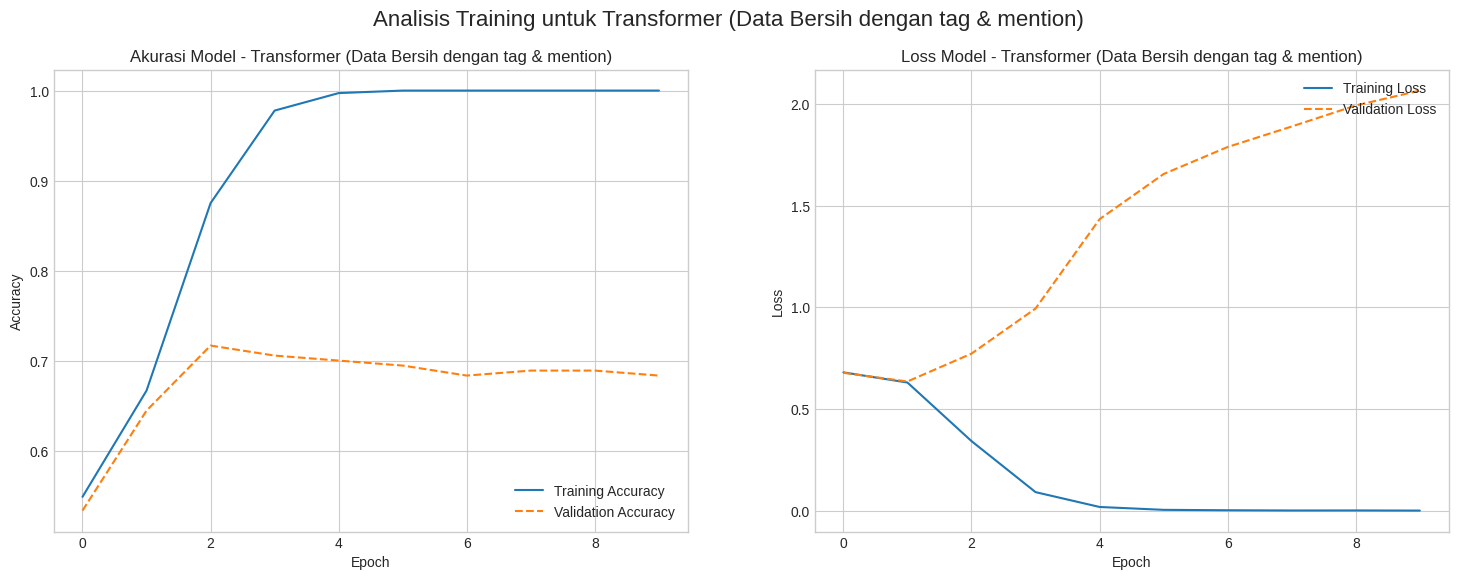


--- Mengevaluasi Model Transformer (Data Bersih dengan tag & mention) pada Data Uji ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step

--- Laporan Klasifikasi (Transformer - Data Bersih dengan tag & mention) ---
              precision    recall  f1-score   support

    negative       0.69      0.66      0.67        90
    positive       0.67      0.71      0.69        90

    accuracy                           0.68       180
   macro avg       0.68      0.68      0.68       180
weighted avg       0.68      0.68      0.68       180



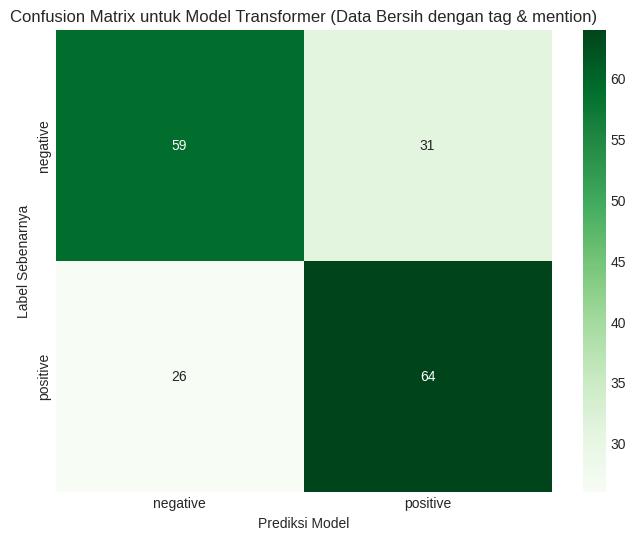

In [ ]:
plot_training_history(history_transformer_clean_withtag, "Transformer (Data Bersih dengan tag & mention)")

# --- Laporan Klasifikasi dan Confusion Matrix (Data Uji) ---
print("\n--- Mengevaluasi Model Transformer (Data Bersih dengan tag & mention) pada Data Uji ---")

y_pred_probs_tf_clean = model_transformer_raw.predict(X_test_clean)
y_pred_tf_clean = np.argmax(y_pred_probs_tf_clean, axis=1)

target_names_clean = label_encoder_clean.classes_

print("\n--- Laporan Klasifikasi (Transformer - Data Bersih dengan tag & mention) ---")
print(classification_report(y_test_clean, y_pred_tf_clean, target_names=target_names_clean))

cm_tf_clean = confusion_matrix(y_test_clean, y_pred_tf_clean)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tf_clean, annot=True, fmt='d', cmap='Greens', xticklabels=target_names_clean, yticklabels=target_names_clean)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix untuk Model Transformer (Data Bersih dengan tag & mention)')
plt.show()

## Eksperimen bagian cleaning data

In [ ]:
import pandas as pd
import re
from tqdm import tqdm
tqdm.pandas()

# --- 1. Daftar Stopword Manual (Sangat Minimalis) ---
# Kita HANYA menghapus kata-kata yang benar-benar netral.
# Perhatikan: 'tidak', 'bukan', 'jangan', 'tapi', 'kurang' TIDAK dihapus.
NEW_STOPWORDS = set([
    'di', 'ke', 'dari', 'dan', 'ini', 'itu', 'adalah', 'para', 'oleh', 'saat',
    'seperti', 'nya', 'ia', 'saja', 'lalu', 'pula', 'pun', 'serta', 'yaitu',
    'yakni', 'wahai', 'sebuah', 'dengan', 'untuk', 'pada', 'kepada', 'bagi'
])

# --- 2. Daftar Slang Manual (Fokus pada Normalisasi) ---
# Kita ubah slang/singkatan penting ke bentuk baku, dan hapus noise (tawa).
NEW_SLANG_MAP = {
    # Normalisasi Negasi (SANGAT PENTING)
    'ga': 'tidak', 'gak': 'tidak', 'tdk': 'tidak', 'ngga': 'tidak',
    'nggak': 'tidak', 'enggak': 'tidak', 'engga': 'tidak', 'bkn': 'bukan',
    'jgn': 'jangan', 'blm': 'belum',

    # Normalisasi Konjungsi
    'tp': 'tapi', 'tpi': 'tapi', 'krn': 'karena', 'dgn': 'dengan',
    'utk': 'untuk', 'dg': 'dengan', 'dlm': 'dalam',

    # Normalisasi Umum
    'yg': 'yang', 'dpt': 'dapat', 'dr': 'dari', 'kpd': 'kepada',
    'sdh': 'sudah', 'klo': 'kalau', 'kalo': 'kalau', 'kl': 'kalau',
    'bgt': 'banget', 'sm': 'sama', 'lg': 'lagi', 'dlu': 'dulu',
    'gini': 'begini', 'gitu': 'begitu', 'skrg': 'sekarang',
    'sy': 'saya', 'gw': 'saya', 'gua': 'saya', 'anda': 'kamu',

    # Penghapusan Noise (Tawa & Partikel tidak penting)
    'wkwk': '', 'wkwkwk': '', 'haha': '', 'hehe': '', 'hihi': '',
    'sih': '', 'deh': '', 'kok': '', 'aja': '', 'dong': '', 'nih': '', 'sih': ''
}

In [ ]:
def preprocess_light(text):
    if not isinstance(text, str):
        return ""

    # 1. Case Folding
    text = text.lower()

    # 2. Cleaning Links & Mentions
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Normalisasi Hashtag (simbolnya dihapus, katanya dibiarkan)
    text = text.replace('#', '')

    # 4. Hapus Angka dan Tanda Baca (kecuali spasi)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 5. Hapus Spasi Berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    # 6. Normalisasi Slang & Hapus Stopword
    words = text.split()
    processed_words = []

    for word in words:
        if word in NEW_SLANG_MAP:
            normalized_word = NEW_SLANG_MAP[word]
            # Jika normalisasinya bukan string kosong (misal: 'gak' -> 'tidak')
            if normalized_word:
                processed_words.append(normalized_word)
            # Jika string kosong (misal: 'wkwk' -> ''), kata itu dihilangkan

        # Hanya tambahkan kata jika BUKAN stopword
        elif word not in NEW_STOPWORDS:
            processed_words.append(word)

    # 7. Gabungkan kembali (TANPA STEMMING)
    return ' '.join(processed_words)

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

# Pastikan df_pilkada_clean (dari sel sebelumnya) sudah ada
if 'df_pilkada_clean' in locals():

    print("Memulai pra-pemrosesan ringan pada data...")
    tqdm.pandas(desc="Processing texts")

    # 1. Terapkan fungsi baru untuk membuat kolom 'text_clean' baru
    #    Kita menggunakan salinan .copy() agar tidak mengubah DataFrame asli secara tidak sengaja
    df_processed = df_pilkada_clean.copy()
    df_processed['text_clean'] = df_processed['text'].progress_apply(preprocess_light)

    print("\nPra-pemrosesan ringan selesai.")

    # 2. Hapus baris yang teksnya jadi kosong setelah dibersihkan
    #    Ini penting agar model tidak dilatih pada data kosong
    df_processed.dropna(subset=['text_clean'], inplace=True)
    df_processed = df_processed[df_processed['text_clean'].str.len() > 0]

    # 3. Tampilkan perbandingan teks asli dan teks bersih (versi ringan)
    print("Berikut perbandingan teks asli dan teks bersih (versi ringan):")
    display(df_processed[['text', 'text_clean']].sample(10))

    # 4. Simpan ke file Feather baru
    #    Kita hanya menyimpan kolom yang relevan untuk training
    df_to_save = df_processed[['text', 'text_clean', 'sentiment']]

    save_path_light = os.path.join(DATA_DIR, 'sentiment_pilkada_light_clean.feather')
    df_to_save.to_feather(save_path_light)

    print(f"\nTotal data setelah dibersihkan: {len(df_to_save)}")
    print(f"Data bersih (versi ringan) berhasil disimpan di: {save_path_light}")
    print("\nFile .feather sekarang berisi kolom 'text', 'text_clean', dan 'sentiment'.")

else:
    print("\nERROR: Variabel 'df_pilkada_clean' tidak ditemukan.")
    print("Pastikan Anda sudah memuat 'dataset_tweet_sentiment_pilkada_DKI_2017.csv' ke dalamnya.")

Memulai pra-pemrosesan ringan pada data...


Processing texts: 100%|██████████| 900/900 [00:00<00:00, 54418.87it/s]


Pra-pemrosesan ringan selesai.
Berikut perbandingan teks asli dan teks bersih (versi ringan):


,text,text_clean
111,AHY Sangat Cemas Terhadap Situasi Sosial Usai ...,ahy sangat cemas terhadap situasi sosial usai ...
872,... #AniesSandy <OK HAND> untuk Jakarta yang...,aniessandy ok hand jakarta yang lebih baik
196,Apapun hasilnya kau tetap kebanggaan kami #Agu...,apapun hasilnya kau tetap kebanggaan kami agus...
42,"secara kesatria dan lapang dada ternyata hoax,...",secara kesatria lapang dada ternyata hoax yang...
741,Ahok 100% masuk akal Anies 100% manis-manis bu...,ahok masuk akal anies manismanis bullshit deba...
463,Untuk bpk@basuki_btp terima kasih untuk perjua...,bpkbasukibtp terima kasih perjuanganmu selama ...
423,Kuota @aagym lagi habis makanya tidak mengikut...,kuota aagym lagi habis makanya tidak mengikuti...
388,"Stress, guberner yang didukung tidak diharapka...",stress guberner yang didukung tidak diharapkan...
690,Akun @CangHaris akun provokator & bukan bagian...,akun cangharis akun provokator bukan bagian ti...
663,"Sudah Curang, Kalah, itulah kekalahan yang san...",sudah curang kalah itulah kekalahan yang sanga...



Total data setelah dibersihkan: 900
Data bersih (versi ringan) berhasil disimpan di: /content/sentiment_pilkada_light_clean.feather

File .feather sekarang berisi kolom 'text', 'text_clean', dan 'sentiment'.


In [ ]:
df_pilkada_clean_light = pd.read_feather('/content/sentiment_pilkada_light_clean.feather')
print("Data bersih berhasil dimuat kembali!")

display(df_pilkada_clean_light.head())

Data bersih berhasil dimuat kembali!


,text,text_clean,sentiment
0,Banyak akun kloning seolah2 pendukung #agussil...,banyak akun kloning seolah pendukung agussilvy...,negative
1,#agussilvy bicara apa kasihan yaa...lap itu ai...,agussilvy bicara apa kasihan yaalap air matany...,negative
2,Kalau aku sih gak nunggu hasil akhir QC tp lag...,kalau aku tidak nunggu hasil akhir qc tapi lag...,negative
3,Kasian oh kasian dengan peluru 1milyar untuk t...,kasian oh kasian peluru milyar tiap rw agussil...,negative
4,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...,maaf ya pendukung agussilvyhayo dukung aniessa...,negative


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# --- 1. AMBIL DATA DARI KOLOM 'text_clean' ---
texts_clean = df_pilkada_clean_light['text_clean'].astype(str).values
labels_clean = df_pilkada_clean_light['sentiment'].values

# --- 2. BUAT TOKENIZER BARU UNTUK DATA BERSIH ---
vocab_size_clean = 10000
oov_token_clean = "<OOV>"

tokenizer_clean = Tokenizer(num_words=vocab_size_clean, oov_token=oov_token_clean)
tokenizer_clean.fit_on_texts(texts_clean)

# Ubah teks menjadi sekuens
sequences_clean = tokenizer_clean.texts_to_sequences(texts_clean)

# --- 3. PADDING SEQUENCES ---
maxlen_clean = 100 # Samakan panjangnya
padded_clean = pad_sequences(sequences_clean, maxlen=maxlen_clean, padding='post', truncating='post')

# --- 4. ENCODE LABELS ---
label_encoder_clean = LabelEncoder()
encoded_labels_clean = label_encoder_clean.fit_transform(labels_clean)
num_labels_clean = len(np.unique(encoded_labels_clean))

# --- 5. SPLIT DATA BERSIH ---
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    padded_clean, encoded_labels_clean, test_size=0.2, random_state=42, stratify=encoded_labels_clean
)

print("Data bersih (clean) berhasil di-tokenize dan di-split:")
print(f"Bentuk X_train_clean: {X_train_clean.shape}")
print(f"Bentuk X_test_clean: {X_test_clean.shape}")

Data bersih (clean) berhasil di-tokenize dan di-split:
Bentuk X_train_clean: (720, 100)
Bentuk X_test_clean: (180, 100)


In [ ]:
# --- Latih Model ---
print("\n--- Memulai Training Model Transformer ---")
batch_size = 32
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history_transformer_clean_withouttag = model_transformer_raw.fit(
    X_train_clean, y_train_clean,
    batch_size=batch_size,
    epochs=10,
    validation_data=(X_test_clean, y_test_clean),
    # callbacks=[early_stopping]
)

print("\n--- Training Model Transformer) Selesai ---")


--- Memulai Training Model Transformer ---
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.5320 - loss: 1.8792 - val_accuracy: 0.5000 - val_loss: 0.7049
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 290ms/step - accuracy: 0.5073 - loss: 0.6982 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.5243 - loss: 0.6874 - val_accuracy: 0.5000 - val_loss: 0.6922
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.5010 - loss: 0.6733 - val_accuracy: 0.5833 - val_loss: 0.6919
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.7902 - loss: 0.5654 - val_accuracy: 0.6444 - val_loss: 0.8166
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.9017 - loss: 0.3805 - val_accuracy: 0.6111 - val_loss: 1.0042
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9527 - loss: 0.1814 - val_accuracy: 0.6333 - val_loss: 1.4008
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accura

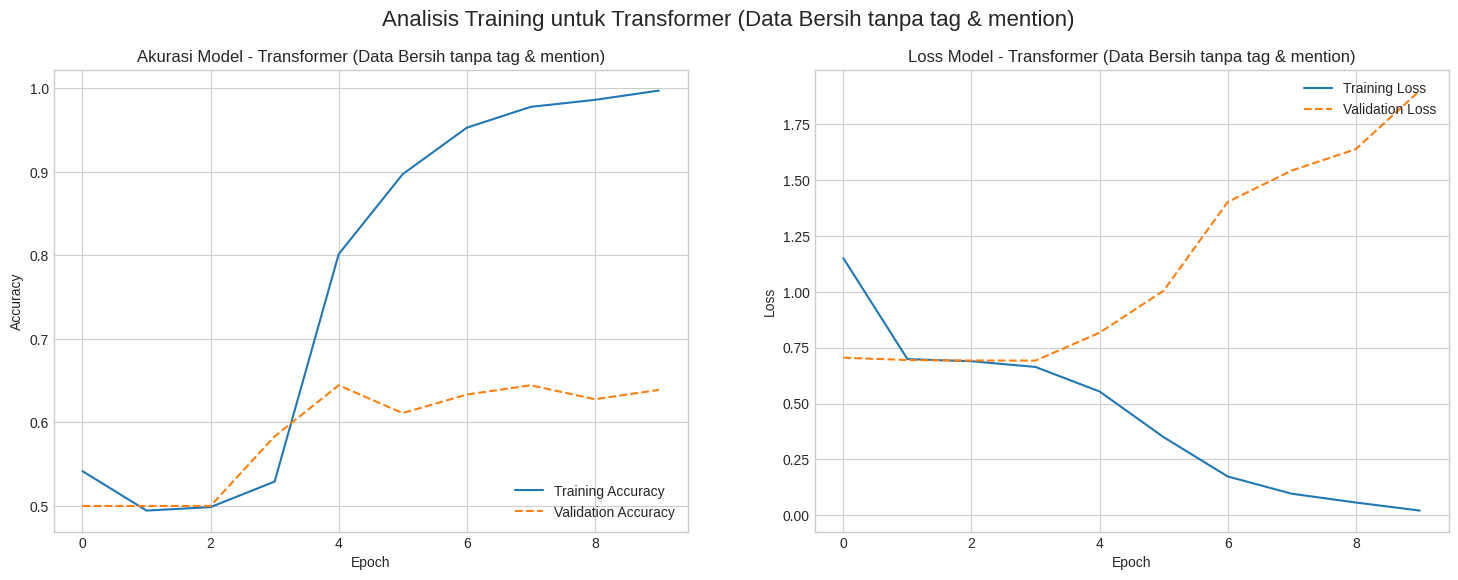


--- Mengevaluasi Model Transformer (Data Bersih tanpa tag & mention) pada Data Uji ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

--- Laporan Klasifikasi (Transformer - Data Bersih tanpa tag & mention) ---
              precision    recall  f1-score   support

    negative       0.63      0.67      0.65        90
    positive       0.65      0.61      0.63        90

    accuracy                           0.64       180
   macro avg       0.64      0.64      0.64       180
weighted avg       0.64      0.64      0.64       180



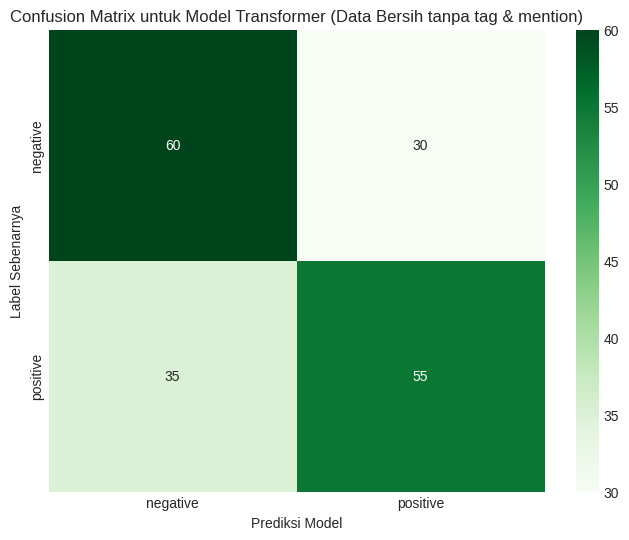

In [ ]:
plot_training_history(history_transformer_clean_withouttag, "Transformer (Data Bersih tanpa tag & mention)")

# --- Laporan Klasifikasi dan Confusion Matrix (Data Uji) ---
print("\n--- Mengevaluasi Model Transformer (Data Bersih tanpa tag & mention) pada Data Uji ---")

y_pred_probs_tf_clean = model_transformer_raw.predict(X_test_clean)
y_pred_tf_clean = np.argmax(y_pred_probs_tf_clean, axis=1)

target_names_clean = label_encoder_clean.classes_

print("\n--- Laporan Klasifikasi (Transformer - Data Bersih tanpa tag & mention) ---")
print(classification_report(y_test_clean, y_pred_tf_clean, target_names=target_names_clean))

cm_tf_clean = confusion_matrix(y_test_clean, y_pred_tf_clean)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tf_clean, annot=True, fmt='d', cmap='Greens', xticklabels=target_names_clean, yticklabels=target_names_clean)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix untuk Model Transformer (Data Bersih tanpa tag & mention)')
plt.show()

## Eksperimen menggunakan Pretrained model fasttext

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
!gunzip cc.id.300.bin.gz

--2025-11-07 10:18:22--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.132.6, 18.173.132.17, 18.173.132.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.132.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4507049071 (4.2G) [application/octet-stream]
Saving to: ‘cc.id.300.bin.gz’

cc.id.300.bin.gz    100%[===================>]   4.20G   247MB/s    in 33s     

2025-11-07 10:18:56 (129 MB/s) - ‘cc.id.300.bin.gz’ saved [4507049071/4507049071]



In [ ]:
!pip install fasttext

In [ ]:
import fasttext
import numpy as np

ft = fasttext.load_model('cc.id.300.bin')

embedding_dim_ft = 300  # Dimensi FastText adalah 300
word_index_raw = tokenizer_raw.word_index
vocab_size_raw = 10000 # Pastikan sama dengan tokenizer_raw

embedding_matrix_ft = np.zeros((vocab_size_raw, embedding_dim_ft))

print("Membuat matriks embedding FastText untuk data mentah...")
for word, i in word_index_raw.items():
    if i < vocab_size_raw:
        embedding_vector = ft.get_word_vector(word)
        if embedding_vector is not None:
            embedding_matrix_ft[i] = embedding_vector

print(f"Matriks Embedding berhasil dibuat dengan bentuk: {embedding_matrix_ft.shape}")

Membuat matriks embedding FastText untuk data mentah...
Matriks Embedding berhasil dibuat dengan bentuk: (10000, 300)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, MultiHeadAttention, Dense,
    LayerNormalization, GlobalAveragePooling1D, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- Parameter Model (disesuaikan dengan FastText) ---
embed_dim = 300      # Dimensi Embedding dari FastText
num_heads = 5       # Jumlah Attention Heads (300 / 5 = 60, angka yang baik)
ff_dim = 128         # Ukuran lapisan Feed Forward

# --- Pastikan variabel ini ada dari split data MENTAH ---
# X_train_raw, y_train_raw, X_test_raw, y_test_raw
# maxlen_raw, vocab_size_raw, num_labels_raw

inputs_ft = Input(shape=(maxlen_raw,))

# --- Layer Embedding (Menggunakan Bobot FastText) ---
token_embedding_layer_ft = Embedding(
    input_dim=vocab_size_raw,
    output_dim=embed_dim,
    weights=[embedding_matrix_ft], # <- Inisialisasi bobot pre-trained
    input_length=maxlen_raw,
    trainable=False                 # <- Bekukan bobotnya!
)
token_embeddings_ft = token_embedding_layer_ft(inputs_ft)

# --- Positional Encoding (Tetap dilatih) ---
pos_embedding_layer_ft = Embedding(input_dim=maxlen_raw, output_dim=embed_dim)
positions = tf.range(start=0, limit=maxlen_raw, delta=1)
pos_embeddings_ft = pos_embedding_layer_ft(positions)

x_ft = token_embeddings_ft + pos_embeddings_ft

# --- Transformer Encoder Block ---
attn_output_ft = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x_ft, x_ft)
attn_output_ft = Dropout(0.2)(attn_output_ft) # Dropout sedikit lebih tinggi
out1_ft = LayerNormalization(epsilon=1e-6)(x_ft + attn_output_ft)

ffn_output_ft = Dense(ff_dim, activation="relu")(out1_ft)
ffn_output_ft = Dense(embed_dim)(ffn_output_ft)
ffn_output_ft = Dropout(0.2)(ffn_output_ft)
x_ft = LayerNormalization(epsilon=1e-6)(out1_ft + ffn_output_ft)

# --- Classification Head ---
x_ft = GlobalAveragePooling1D()(x_ft)
x_ft = Dropout(0.2)(x_ft)
x_ft = Dense(64, activation="relu")(x_ft)
x_ft = Dropout(0.2)(x_ft)
outputs_ft = Dense(num_labels_raw, activation="softmax")(x_ft)

model_transformer_ft_raw = Model(inputs=inputs_ft, outputs=outputs_ft)
model_transformer_ft_raw.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print("--- Arsitektur Model Transformer (Data Mentah + FastText) ---")
model_transformer_ft_raw.summary()


# --- 3. Latih Model ---
print("\n--- Memulai Training Model Transformer (Data Mentah + FastText) ---")
batch_size = 32
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history_transformer_ft_raw = model_transformer_ft_raw.fit(
    X_train_raw, y_train_raw,
    batch_size=batch_size,
    epochs=10,
    validation_data=(X_test_raw, y_test_raw),
    # callbacks=[early_stopping]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


--- Arsitektur Model Transformer (Data Mentah + FastText) ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 100, 300)  │  3,000,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 100, 300)  │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 300)  │  1,804,800 │ add_6[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 100, 300)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 100, 300)  │          0 │ add_6[0][0],      │
│                     │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 300)  │        600 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 100, 128)  │     38,528 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 100, 300)  │     38,700 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 100, 300)  │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 100, 300)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 300)  │        600 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 300)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 300)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │     19,264 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 2)         │        130 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,902,622 (18.70 MB)

 Trainable params: 1,902,622 (7.26 MB)

 Non-trainable params: 3,000,000 (11.44 MB)


--- Memulai Training Model Transformer (Data Mentah + FastText) ---
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5431 - loss: 0.7898 - val_accuracy: 0.5833 - val_loss: 0.6793
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5564 - loss: 0.6818 - val_accuracy: 0.5722 - val_loss: 0.6798
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6086 - loss: 0.6492 - val_accuracy: 0.6611 - val_loss: 0.6053
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6944 - loss: 0.5825 - val_accuracy: 0.6556 - val_loss: 0.5835
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7679 - loss: 0.5155 - val_accuracy: 0.6667 - val_loss: 0.6083
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7376 - loss: 0.5313 - val_accuracy: 0.7111 - val_loss: 0.6227
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7866 - loss: 0.4847 - val_accuracy: 0.7611 - val_loss: 0.5155
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step


--- Mengevaluasi Hasil Training Model Transformer (Data Mentah + FastText) ---


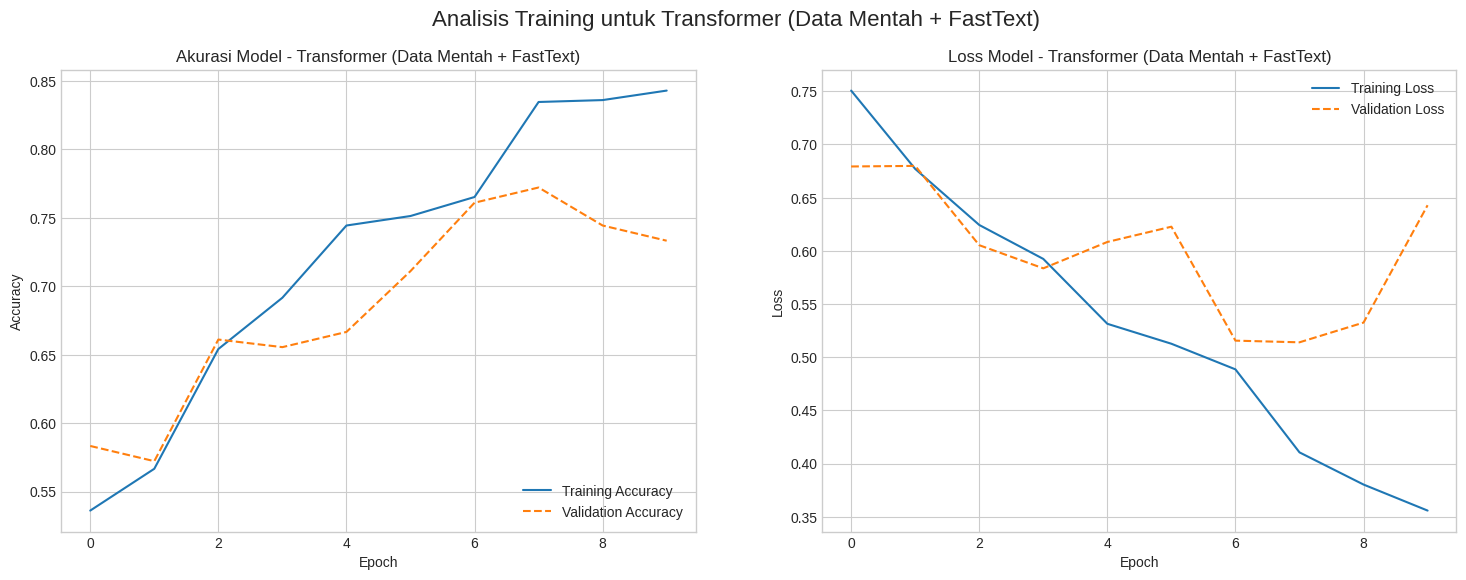


--- Mengevaluasi Model Transformer (Data Mentah + FastText) pada Data Uji ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step

--- Laporan Klasifikasi (Transformer - Data Mentah + FastText) ---
              precision    recall  f1-score   support

    negative       0.74      0.72      0.73        90
    positive       0.73      0.74      0.74        90

    accuracy                           0.73       180
   macro avg       0.73      0.73      0.73       180
weighted avg       0.73      0.73      0.73       180


--- Matriks Kebingungan (Transformer - Data Mentah + FastText) ---


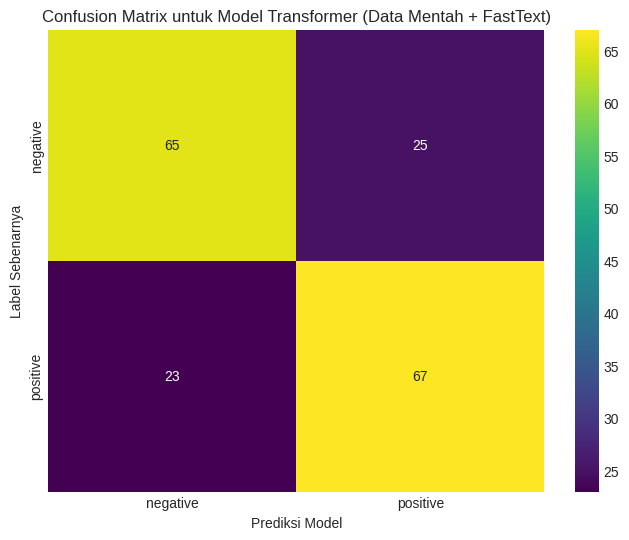

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- 4.1. Visualisasi Hasil Training ---
print("\n--- Mengevaluasi Hasil Training Model Transformer (Data awal + FastText) ---")
plot_training_history(history_transformer_ft_raw, "Transformer (Data awal + FastText)") # Gunakan fungsi plot dari sel sebelumnya

# --- 4.2. Laporan Klasifikasi dan Confusion Matrix (Data Uji) ---
print("\n--- Mengevaluasi Model Transformer (Data awal + FastText) pada Data Uji ---")

y_pred_probs_tf_ft_raw = model_transformer_ft_raw.predict(X_test_raw)
y_pred_tf_ft_raw = np.argmax(y_pred_probs_tf_ft_raw, axis=1)

target_names_raw = label_encoder_raw.classes_

print("\n--- Laporan Klasifikasi (Transformer - Data awal + FastText) ---")
print(classification_report(y_test_raw, y_pred_tf_ft_raw, target_names=target_names_raw))

print("\n--- Matriks Kebingungan (Transformer - Data awal + FastText) ---")
cm_tf_ft_raw = confusion_matrix(y_test_raw, y_pred_tf_ft_raw)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tf_ft_raw, annot=True, fmt='d', cmap='viridis', xticklabels=target_names_raw, yticklabels=target_names_raw)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix untuk Model Transformer (Data awal + FastText)')
plt.show()